In [1]:
import os
from ae_functions import get_folder_pickle_files
from load_data import *
import matplotlib.pyplot as plt
from ae_functions import *
from torch.utils.data import DataLoader
import numpy as np
from acoustic_emission_dataset import AcousticEmissionDataset

# Load AE Dataset

In [3]:
# SIGNAL PROCESSING CONSTANTS
SIG_LEN = 1024           # [samples / signal] ;
DT = 10**-7              # [seconds] ; sample period / time between samples
LOW_PASS = 0      # [Hz] ; low frequency cutoff
HIGH_PASS = 100*10**4    # [Hz] ; high frequency cutoff
FFT_UNITS = 1000         # FFT outputs in Hz, this converts to kHz
NUM_BINS = 26            # For partial power

# FILE I/O
JSON_DATA_FILE = 'E:/file_cabinet/phd/projects/plb_dataset_supervised_learning/Data/220426_PLB_data.json'

# Load AE data
ae_dataset = AcousticEmissionDataset(JSON_DATA_FILE,SIG_LEN,DT,LOW_PASS,
                                     HIGH_PASS,FFT_UNITS,NUM_BINS,0,0)

angles = ae_dataset.angles # what the one hot encoded targets map to
num_classes = len(angles)  # how many diff angles, for model output dim
example_feature_vec, _ = ae_dataset[0] # to determine feature dim
feature_dim = example_feature_vec.shape[0] # for model creation input dim

print(f"Available angles: {angles}")

targets_one_hot is the one hot encoding for angle. ex: [1 0 1]

Shape of waves is: torch.Size([514, 1024])
Datatype of waves is: torch.float32
waves requires grad: False
Shape of targets is: torch.Size([514])
Datatype of targets is: torch.int64
targets requires grad: False
Ex: 0
Shape of targets_one_hot is: torch.Size([514, 6])
Datatype of targets_one_hot is: torch.float32
targets_one_hot requires grad: False
Ex: tensor([1, 0, 0, 0, 0, 0])

AcousticEmissionDataset loaded in!

Available angles: ['20deg' '22deg' '26deg' '30deg' '36deg' '40deg']


In [5]:
ae_dataset[0]

(tensor([ 6.3653, 10.3271, 27.0146, 27.6198, 25.5796, 10.9856, 16.7260, 20.9248,
         23.1406, 44.5586, 33.9402, 47.4952, 21.4593, 23.4462, 17.2663, 17.2920,
          5.1659,  2.3205,  1.9205,  1.7625,  3.2957,  5.1567,  6.8026,  8.2135,
         12.6282,  6.0129,  5.4142,  8.6007,  7.3900,  8.9495,  6.5379,  4.0683,
          1.9425,  1.9978,  1.7142,  1.3237,  2.3246,  3.3797,  1.4863,  1.5051,
          5.0424,  4.1638,  4.1282,  5.5319,  1.8895,  3.4690,  3.7771,  2.2345,
          4.7743,  3.4331,  2.5152,  4.9806,  2.2891,  0.1532,  4.2911,  3.3128,
          0.0816,  3.7439,  3.8018,  3.8576,  4.6412,  3.9016,  4.3710,  3.6625,
          1.8010,  3.6876,  3.2199,  0.9679,  3.0284,  0.8054,  1.5290,  1.5245,
          0.4621,  1.5498,  0.9309,  0.3782,  0.3856,  0.9054,  0.7695,  0.8083,
          0.7703,  1.4343,  0.9207,  0.6870,  0.4579,  0.8647,  1.0194,  0.2841,
          0.4505,  0.6295,  0.2793,  0.2812,  0.2042,  0.3098,  0.3068,  0.5004,
          0.3843,  0.1922,  

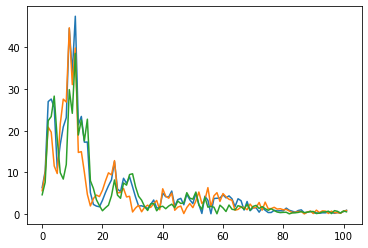

In [10]:
x,y=ae_dataset[0]
plt.plot(x)
x,y=ae_dataset[50]
plt.plot(x)
x,y=ae_dataset[100]
plt.plot(x)

# Load Experimental Data

In [22]:
EXPERIMENT = 6
data=load_experiment_results(EXPERIMENT)

Retrieved data (1 pickle files) from E:\file_cabinet\phd\projects\plb_dataset_supervised_learning\supervised_learning\nn_classification/experiment_06/


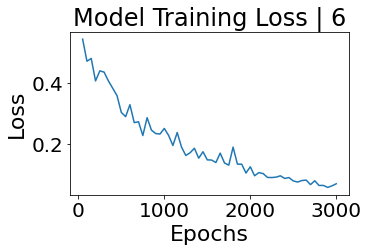

In [23]:
x = np.linspace(0,data['EPOCHS'],int(data['EPOCHS']/50)+1)

create_figure('', 1, 1, width=5, height=3,
                  suptitle_font_size=20, default_font_size=10,
                  title_font_size=24, axes_font_size=22, tick_font_size=20,
                  legend_font_size=10, w_space=0.25, h_space=0.25)

plt.plot(x[1:],data['Loss'][1:])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Model Training Loss | {EXPERIMENT}')
plt.show()

# Load Trained Model

In [7]:
pth_path = './experiment_01/nn01_3000_0.001_adam_mse.pth'
model_num = 1
feature_dim = 1024
model = load_model(pth_path, model_num, feature_dim,num_classes=6)

NeuralNetwork_01(
  (layers): Sequential(
    (0): Linear(in_features=1024, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=6, bias=True)
  )
)


# Evaluated Trained Model on Waveforms of Specific Angle

In [6]:
test_angles = ['20deg']
test_data = ae_dataset._get_angle_subset(test_angles)
test_data_loader = DataLoader(test_data)
len(test_data)

76

In [8]:
# Separate data into training data and test data  
total_count = len(ae_dataset)
train_percent = 0.80
test_percent = 1 - train_percent
train_count = int(train_percent * total_count)
test_count = total_count - train_count
train_seed = 41 # THIS ENSURES SAME SPLIT FOR TEST DATA EVERY RUN
torch.manual_seed(train_seed) 
train_data, test_data = torch.utils.data.random_split(ae_dataset,
                                                      (train_count,
                                                        test_count))

# Create data loaders
test_data_loader = DataLoader(test_data)

# Evaluate model accuracy on test data set
model.eval()
with torch.no_grad():
    test_predicted = []
    test_actual = []
    total_examples = 0
    #total_correct = 0
    for inputs, targets in test_data_loader:
        prediction = model(inputs) # Tensor (1,3) -> ex. [0.1, 0.01,0.6]
        #prediction = prediction[0].argmax()
        #actual = targets[0].argmax()
        test_predicted.append(prediction) # ex. [0,0,1]
        test_actual.append(targets)
        total_examples = total_examples + 1
        #print(targets.dtype)
        #if prediction == actual:
        #    total_correct = total_correct + 1

test_actual = torch.tensor(test_actual, device = 'cpu')
test_predicted = torch.tensor(test_predicted, device = 'cpu')


create_figure('', 1, 1, width=5, height=3,
                  suptitle_font_size=18, default_font_size=10,
                  title_font_size=22, axes_font_size=18, tick_font_size=20,
                  legend_font_size=14, w_space=0.25, h_space=0.25)

#print(test_predicted[ii])
#plt.scatter(test_predicted[1],test_actual[1])

for ii in range(0,len(test_predicted)):
    if test_actual[ii] == 20.0:
        plt.scatter(test_actual[ii],test_predicted[ii],color='b')
    if test_actual[ii] == 22.0:
        plt.scatter(test_actual[ii],test_predicted[ii],color='g')
    if test_actual[ii] == 26.0:
        plt.scatter(test_actual[ii],test_predicted[ii],color='r')
    if test_actual[ii] == 30.0:
        plt.scatter(test_actual[ii],test_predicted[ii],color='m')
    if test_actual[ii] == 36.0:
        plt.scatter(test_actual[ii],test_predicted[ii],color='orange')
    if test_actual[ii] == 40.0:
        plt.scatter(test_actual[ii],test_predicted[ii],color='cyan')


ValueError: only one element tensors can be converted to Python scalars

In [7]:
model.eval()
with torch.no_grad():
    test_predicted = []
    for inputs, targets in test_data_loader: # loop through all examples
        prediction = model(inputs)  # trained model prediction
        test_predicted.append(prediction.numpy()) # save prediction
        
test_predicted = np.array(test_predicted)
test_predicted = test_predicted.flatten()

NameError: name 'model' is not defined

# Visualize Predictions

In [5]:
create_figure('', 1, 1, width=5, height=3,
                  suptitle_font_size=18, default_font_size=10,
                  title_font_size=22, axes_font_size=18, tick_font_size=20,
                  legend_font_size=14, w_space=0.25, h_space=0.25)

mean = test_predicted.mean()
std = test_predicted.std()
plt.hist(test_predicted,bins=30)
plt.axvline(test_predicted.mean(),color='red',linestyle='--',label=f'Mean: {mean:.3g}')
plt.axvline(mean+std,color='purple',linestyle='--',label=f'Std: {std:.3g}')
plt.axvline(mean-std,color='purple',linestyle='--')
plt.ylabel('Num Predicted')
plt.xlabel('Angle (deg)')
plt.xlim([15, 45])
plt.title(f'Model Predictions on {test_angles[0]}')
plt.legend()
plt.show()

NameError: name 'test_predicted' is not defined

<Figure size 360x216 with 0 Axes>